
[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


2025-10-28 16:33:05,585 - INFO - ✅ Berhasil memuat file gojek_news_preprocessed_final.csv


Parameter terbaik: {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_features': 7000}
Skor rata-rata terbaik (CV): 0.87

🎯 Akurasi Model pada Test Set: 0.90

📊 Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.94      0.80      0.86        20
      netral       1.00      0.95      0.97        20
     positif       0.79      0.95      0.86        20

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60


🔮 Hasil Prediksi Teks Baru:
• 'Gojek memberikan pelayanan yang sangat memuaskan dan cepat!' → positif
• 'Banyak pengemudi Gojek yang mengeluh tentang potongan biaya aplikasi.' → positif
• 'Tarif Gojek baru membuat pelanggan sedikit keberatan.' → positif
• 'Layanan GoFood membantu UMKM lokal berkembang pesat.' → positif


/var/folders/77/vv2j_079111byz0tpny0xplc0000gp/T/ipykernel_12701/2592083918.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


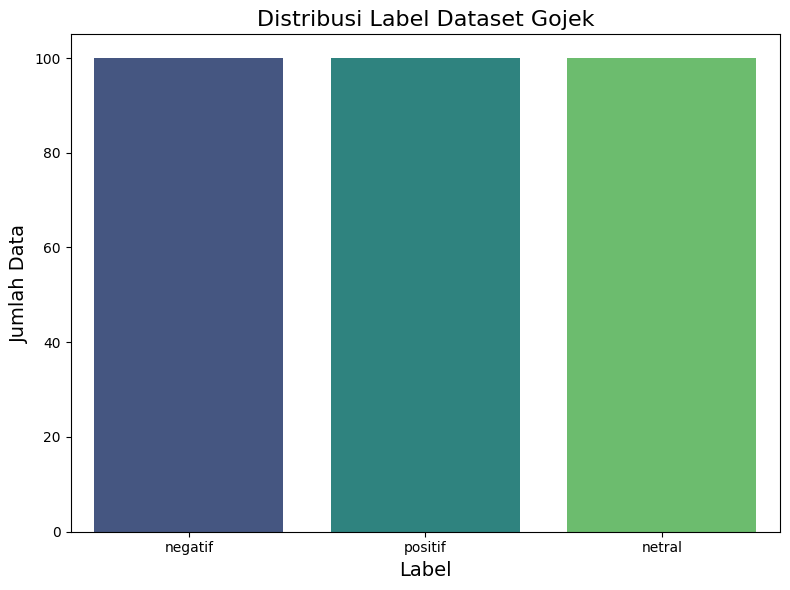

2025-10-28 16:33:08,566 - INFO - Total data: 300
2025-10-28 16:33:08,568 - INFO - Distribusi label:
label
negatif    100
positif    100
netral     100
2025-10-28 16:33:08,569 - INFO - Akurasi model: 0.90


In [3]:
# ================================================================
# 🤖 TRAINING MODEL SENTIMEN GOJEK - TF-IDF + NAIVE BAYES
# ================================================================

# Install required packages
!pip uninstall nltk -y -q
!pip install pandas numpy nltk Sastrawi wordcloud seaborn matplotlib scikit-learn -q

import pandas as pd
import numpy as np
import re
import logging
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ================================================================
# ⚙️ Setup NLTK
# ================================================================
import shutil, os
for path in nltk.data.path:
    if os.path.exists(path):
        shutil.rmtree(path, ignore_errors=True)

nltk.data.path.append("/Users/irfan/nltk_data")
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
except:
    pass

# ================================================================
# 🧾 Load Dataset
# ================================================================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

try:
    df = pd.read_csv('gojek_news_preprocessed_final.csv')
    logger.info("✅ Berhasil memuat file gojek_news_preprocessed_final.csv")
except FileNotFoundError:
    logger.error("❌ File gojek_news_preprocessed_final.csv tidak ditemukan.")
    raise

required_columns = ['filtered_content', 'label']
if not all(col in df.columns for col in required_columns):
    missing_cols = [col for col in required_columns if col not in df.columns]
    raise ValueError(f"DataFrame tidak memiliki kolom yang diperlukan: {missing_cols}")

# ================================================================
# 🧠 Persiapan Data
# ================================================================
X = df['filtered_content'].fillna('')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================================================
# 🧩 Pipeline TF-IDF + MultinomialNB
# ================================================================
pipeline_nb = make_pipeline(
    TfidfVectorizer(
        stop_words=['yang', 'dan', 'di', 'dengan', 'untuk', 'pada', 'ini', 'dari',
                    'ke', 'dalam', 'tersebut', 'adalah', 'oleh', 'gojek'],
        max_features=5000,
        ngram_range=(1, 2)
    ),
    MultinomialNB()
)

# ================================================================
# 🔍 Grid Search Parameter Tuning
# ================================================================
param_grid = {
    'tfidfvectorizer__max_features': [3000, 5000, 7000],
    'multinomialnb__alpha': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(pipeline_nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Parameter terbaik: {grid_search.best_params_}")
print(f"Skor rata-rata terbaik (CV): {grid_search.best_score_:.2f}")

# ================================================================
# 🧾 Evaluasi Model
# ================================================================
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Akurasi Model pada Test Set: {accuracy:.2f}")
print("\n📊 Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

# ================================================================
# 💬 Prediksi Contoh Teks Baru
# ================================================================
new_texts = [
    "Gojek memberikan pelayanan yang sangat memuaskan dan cepat!",
    "Banyak pengemudi Gojek yang mengeluh tentang potongan biaya aplikasi.",
    "Tarif Gojek baru membuat pelanggan sedikit keberatan.",
    "Layanan GoFood membantu UMKM lokal berkembang pesat."
]

predictions = grid_search.predict(new_texts)

print("\n🔮 Hasil Prediksi Teks Baru:")
for text, pred in zip(new_texts, predictions):
    print(f"• '{text}' → {pred}")

# ================================================================
# 📊 Visualisasi Distribusi Label
# ================================================================
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribusi Label Dataset Gojek', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Jumlah Data', fontsize=14)
plt.tight_layout()
plt.savefig('gojek_label_distribution.png')
plt.show()

# ================================================================
# 📈 Simpan Model & Ringkasan
# ================================================================
logger.info(f"Total data: {len(df)}")
logger.info(f"Distribusi label:\n{df['label'].value_counts().to_string()}")
logger.info(f"Akurasi model: {accuracy:.2f}")
